# Training ANN for predicting shear resistance of concrete beams reinforced by FRP bars

Reference: Shear resistance prediction of concrete beams reinforced by FRP bars using artificial neural networks
https://doi.org/10.1016/j.measurement.2018.05.051

The data from Table A1 of the above paper are saved into train_data.xlsx and loaded in this script for training an ANN using two different training algortihms: Adam and Levenberg-Marquardt. The data contains 6 input variables and one output variable. The latter is the shear resistance calculated according to ACI440.1R.

The fitting is done with a shallow neural network. This script is adjusted from the script published at https://github.com/fabiodimarco/tf-levenberg-marquardt . In this script it is shown that first-order methods such as Adam fail to converge, while Levenberg–Marquardt converges rapidly with very low loss values. The values of learning_rate were chosen experimentally on the basis of the results obtained by each algorithm.


In [33]:
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
# If the module levenberg_marquardt cannot be imported in Google Collab, then You can do this by clicking on the “Files” button on the left-hand side of the Colab interface, and then clicking on the “Upload” button. Once you have uploaded the module file (levenberg_marquardt.py), you can import it in your Colab notebook using a standard Python import statement.
import levenberg_marquardt as lm

In [34]:
input_size = 177  # Update this to match the size of your dataset
batch_size = 18
# Get the directory where this script is located
script_dir=os.getcwd()
print(script_dir)
# Construct the relative path to the Excel file
relative_file_path = 'train_data.xlsx'
excel_file_path = os.path.join(script_dir, relative_file_path)
print(excel_file_path)
# Load training data from Excel file
# If the data cannot be loaded in Google Collab, then upload the Excel file by clicking on the “Files” button on the left-hand side of the Colab interface, and then clicking on the “Upload” button.
train_data = pd.read_excel(excel_file_path, skiprows=0)
# Print dimensions of the data being loaded
print(train_data.shape)
# Separate input and output training data
x_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
# Print dimensions of the x data
print(x_train.shape)
# Print dimensions of the y data
print(y_train.shape)
#print(x_train)
print(y_train)
# Normalize x data
max_values = np.max(x_train, axis=0)
x_train = x_train / max_values
print(max_values)
print(x_train)
# Normalize y data
max_values = np.max(y_train, axis=0)
y_train = y_train / max_values
print(max_values)
print(y_train)


/content
/content/train_data.xlsx
(177, 7)
(177, 6)
(177,)
[157.5312046  158.1569451  148.00991254 143.87835593 119.98278333
  71.72755404  82.13614676  84.35938465  87.51098658  86.41923261
 118.12378078  58.61330235  62.45185498 119.02613925  93.17489421
  80.39413928 102.76702262 102.76702262 102.76702262  83.03406416
  83.03406416  83.03406416 109.17473174 109.17473174 109.17473174
 134.50492596 134.50492596 134.50492596 123.74944419 123.74944419
 123.74944419 112.84443873 112.84443873 112.84443873  90.90884248
  80.59229386  88.0009332  332.09486533 328.11786844 343.30484595
 379.92804887 377.05898763 103.73372416 103.73372416 119.33114418
 119.33114418 106.7553658  106.7553658   89.16933643  89.16933643
  99.38669713  99.38669713  91.32123442  91.32123442 128.36579507
 128.36579507 128.36579507 101.17766075 101.17766075 101.17766075
 113.45020636 113.45020636 113.45020636 143.43647651 143.43647651
 143.43647651  90.36402054 109.73961421 103.92183441 107.43829032
 101.05500634 101

In [35]:
# Convert data to TensorFlow tensors
x_train = tf.constant(x_train, dtype=tf.float32)
y_train = tf.constant(y_train, dtype=tf.float32)
print(x_train)
print(y_train)

tf.Tensor(
[[0.43763676 0.54713804 0.7111111  0.50509626 0.23178808 0.92630154]
 [0.43763676 0.54713804 0.7111111  0.50962627 0.23178808 0.92630154]
 [0.43763676 0.54713804 0.7111111  0.53114384 0.29801324 0.39215687]
 ...
 [0.32822758 0.3627946  0.6666667  0.45639864 0.14569536 0.27721435]
 [0.32822758 0.3594276  0.6666667  0.45639864 0.14569536 0.270453  ]
 [0.32822758 0.3594276  0.6666667  0.45639864 0.14569536 0.270453  ]], shape=(177, 6), dtype=float32)
tf.Tensor(
[0.29265752 0.29382    0.2749691  0.2672936  0.222901   0.13325365
 0.15259047 0.15672074 0.16257572 0.16054748 0.21944739 0.10889032
 0.11602149 0.22112377 0.17309798 0.14935422 0.190918   0.190918
 0.190918   0.1542586  0.1542586  0.1542586  0.20282207 0.20282207
 0.20282207 0.24987988 0.24987988 0.24987988 0.22989862 0.22989862
 0.22989862 0.20963956 0.20963956 0.20963956 0.16888817 0.14972234
 0.16348593 0.6169575  0.60956913 0.6377831  0.7058208  0.7004907
 0.19271392 0.19271392 0.2216904  0.2216904  0.19832744 0.19

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(input_size)
train_dataset = train_dataset.batch(batch_size).cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='tanh', input_shape=(6,)),
    tf.keras.layers.Dense(1, activation='linear')])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.MeanSquaredError())

model_wrapper = lm.ModelWrapper(
    tf.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=lm.MeanSquaredError())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                140       
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [38]:
print("Train using Adam")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=1000)
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)
# loss value: 2.0443e-04

Train using Adam
Epoch 1/1000
10/10 [==============================] - 1s 3ms/step - loss: 0.0291
Epoch 2/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 4/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 6/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 7/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 8/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 9/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 10/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 11/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 12/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 13

In [39]:
print("\n_________________________________________________________________")
print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
model_wrapper.fit(train_dataset, epochs=100)
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)
#loss value: 2.3174e-05


_________________________________________________________________
Train using Levenberg-Marquardt
Epoch 1/100
10/10 [==============================] - 1s 52ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0249
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0039
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 8.6579e-04
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 3.3452e-04
Epoch 5/100
10/10 [==============================] - 0s 21ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 2.0709e-04
Epoch 6/100
10/10 [==============================] - 0s 21ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 1.6423e-04
Epoch 7/100
10/10 [==============================] - 0s 22ms/step - damping_factor: 1.0000e-10 - attempts: 1.00


_________________________________________________________________
Plot results
6/6 [==============================] - 0s 5ms/step


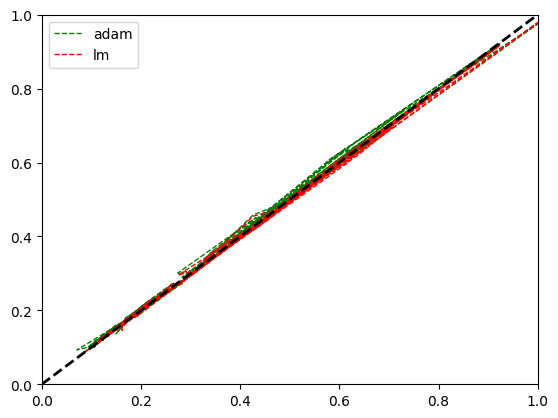

In [45]:
print("\n_________________________________________________________________")
print("Plot results")
#plt.plot(x_train, y_train, 'b-', label="reference")
plt.plot(y_train, model.predict(x_train), 'g--', label="adam", linewidth=1)
plt.plot(y_train, model_wrapper.predict(x_train), 'r--', label="lm", linewidth=1)
plt.legend()
#plt.axis('equal')
plt.xlim([0, 1])  # Set your desired x-axis limits
plt.ylim([0, 1])   # Set your desired y-axis limits
# Add a diagonal dashed line
x = np.linspace(0, 1, 100)
y = x
plt.plot(x, y, linestyle='dashed', color='black', linewidth=2, label='Diagonal Line')

plt.show()
